In [9]:
import torch
import torch.nn as nn
from data import ImageDataset
from model import ViTVelocity
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from contextlib import nullcontext
from utils import train_loop, sample_rectified_flow, make_packing_collate
from torchvision.utils import save_image


data_folder = "../../../cat/"
img_paths = []
import os

for file in os.listdir(data_folder):
    if file.endswith('.png'):
        img_paths.append(os.path.join(data_folder, file))

DS_SIZE = None
NUM_EPOCHS = 500000
SAMPLE_INTERVAL = 10
PRINT_INTERVAL = 1
NOISE_STD = 1
BATCH_SIZE = 64
DEVICE = 'mps'

if DS_SIZE is not None:
    img_paths = img_paths[:DS_SIZE]

transform = v2.Compose([
    v2.ToTensor(),
    v2.Resize((256, 256)),
])

ds = ImageDataset(img_paths, transform=transform)




/opt/anaconda3/envs/AI/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [10]:
samples = [ds[i] for i in range(6)]
save_image(samples, '../../figures/cats_ds.png', nrow=2, normalize=False)

In [70]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from navit_rf.sampling import sample_rectified_flow


def compare_models_over_steps(
    model_no_rectify,
    model_rectify,
    steps_list,
    *,
    device,
    img_size,
    noise_std=1.0,
    solver="heun",
    row_labels=("no rectify", "1 rectify"),
    seed=69,
    title_font=14,
    row_font=14,
):
    """
    Sample two models on the same noise for each steps count and show a 2×N grid.

    Args:
        model_no_rectify / model_rectify: trained velocity models.
        steps_list (List[int]): number of integration steps (one column per entry).
        device: torch device.
        img_size (int): base resolution for sampling (assumes square).
        noise_std (float): init noise std.
        solver (str): 'heun' or 'euler'.
        row_labels (tuple): text labels for the two rows.
        seed (int): manual seed to sync noise across models.
        title_font (int): font size for the column titles (N=…).
        row_font (int): font size for the row labels.
    """
    fig, axes = plt.subplots(
        2, len(steps_list), figsize=(3 * len(steps_list), 6), squeeze=False
    )

    def prep(img):
        img = img[0].detach().cpu()
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        return np.transpose(img.numpy(), (1, 2, 0))

    for col, steps in enumerate(steps_list):
        torch.manual_seed(seed)
        out_no = sample_rectified_flow(
            model_no_rectify,
            n=1,
            device=device,
            img_size=img_size,
            steps=steps,
            noise_std=noise_std,
            solver=solver,
        )

        torch.manual_seed(seed)
        out_rect = sample_rectified_flow(
            model_rectify,
            n=1,
            device=device,
            img_size=img_size,
            steps=steps,
            noise_std=noise_std,
            solver=solver,
        )

        axes[0, col].imshow(prep(out_no))
        axes[0, col].set_title(f"N = {steps}", fontsize=title_font)
        axes[1, col].imshow(prep(out_rect))

        for row in range(2):
            axes[row, col].set_xticks([])
            axes[row, col].set_yticks([])
            for spine in axes[row, col].spines.values():
                spine.set_visible(False)

    axes[0, 0].set_ylabel(row_labels[0], fontsize=row_font, rotation=90)
    axes[1, 0].set_ylabel(row_labels[1], fontsize=row_font, rotation=90)
    axes[0, 0].yaxis.set_label_coords(-0.12, 0.5)
    axes[1, 0].yaxis.set_label_coords(-0.12, 0.5)

    plt.tight_layout()
    plt.show()
    return fig

In [71]:
import navit_rf as nrf

model_no_rect = nrf.ViTVelocity(
    patch=4,
    in_ch=3,
    d_model=512,
    depth=8,
    n_head=8,
    mlp_ratio=4.0,
)
model_no_rect.load_state_dict(torch.load('model_2.pth', map_location='mps'))

model_one_rect = nrf.ViTVelocity(
    patch=4,
    in_ch=3,
    d_model=512,
    depth=8,
    n_head=8,
    mlp_ratio=4.0,
)
model_one_rect.load_state_dict(torch.load('model_2_rect1.pth', map_location='mps'))

<All keys matched successfully>

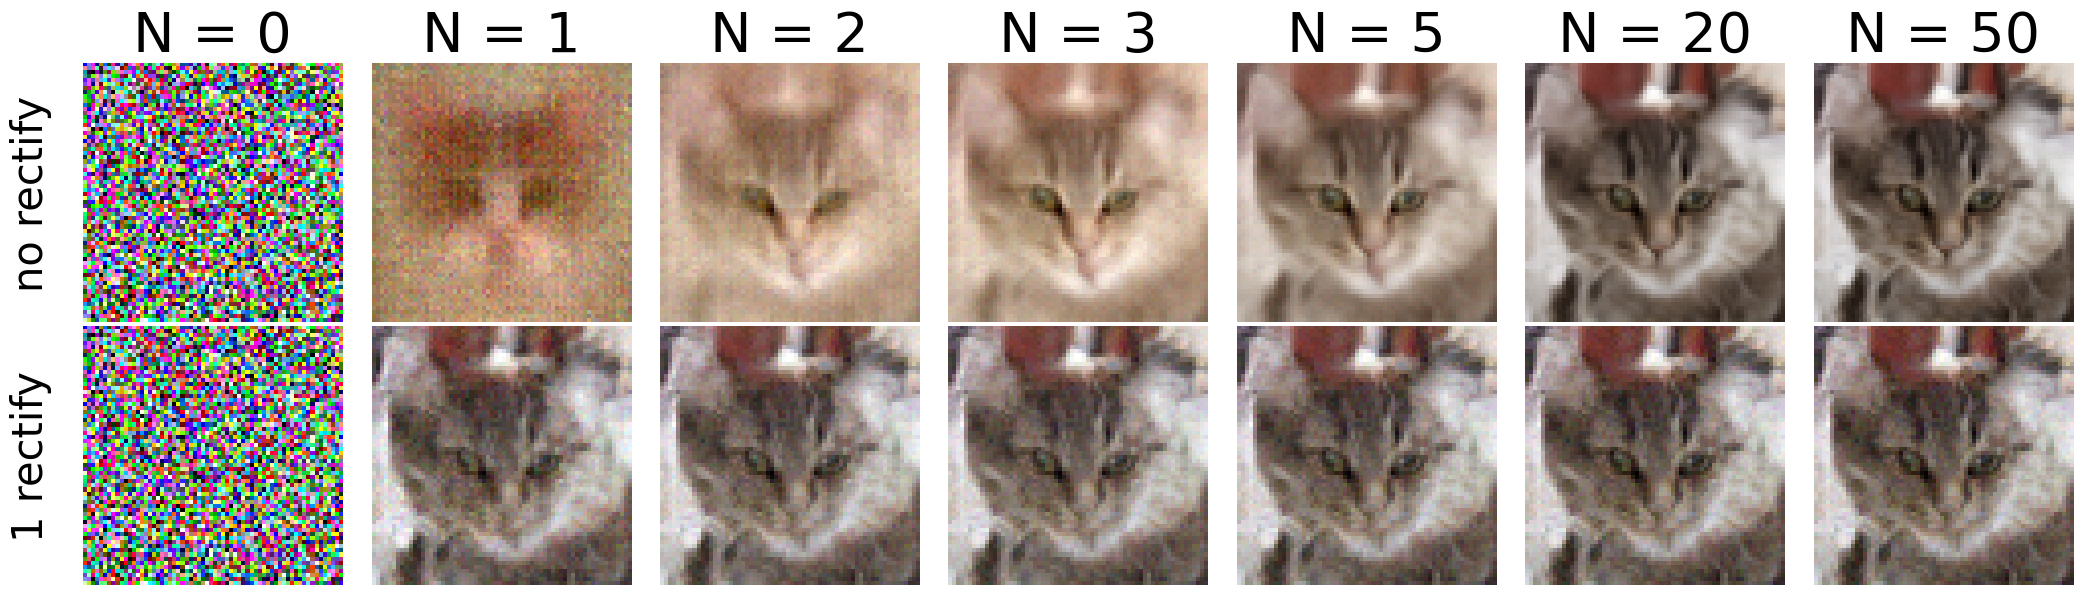

In [82]:
fig = compare_models_over_steps(
    model_no_rect,
    model_one_rect,
    [0, 1, 2, 3, 5, 20, 50],
    device='mps',
    img_size=64,
    noise_std=1.0,
    solver="euler",
    row_labels=("no rectify", "1 rectify"),
    seed=69,
    title_font=40,
    row_font=30
)

In [83]:
fig.savefig("../../figures/0_vs_1rect_1.png", dpi=300, bbox_inches="tight")


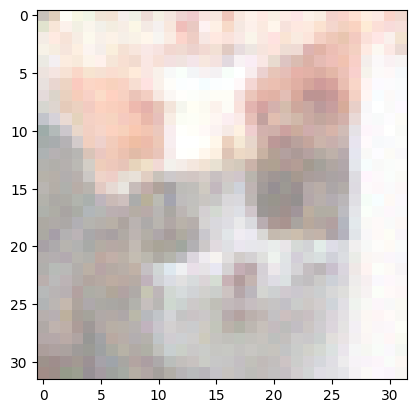

In [58]:
from navit_rf.sampling import sample_rectified_flow

model = nrf.ViTVelocity(
    patch=4,
    in_ch=3,
    d_model=512,
    depth=8,
    n_head=8,
    mlp_ratio=4.0,
)
model.load_state_dict(torch.load('experiments/navit_rf/outputs/checkpoints/vit_velocity_epoch0235.pth', map_location='mps')['model'])

sample = sample_rectified_flow(
        model,
        n=1,
        device=DEVICE,
        img_size=32,
        steps=50,
    )
plt.imshow(sample.squeeze().permute(1,2,0).cpu())

In [68]:
import math
SIZES = [
    (32, 32),
    (36, 36),
    (40, 40),
    (44, 44),
    (48, 48),
    (52, 52),
    (60, 60),
    (64, 64),
]
samples = []
for i in range(len(SIZES)):
    torch.random.manual_seed(69)

    sample = sample_rectified_flow(
        model,
        n=1,
        device=DEVICE,
        img_size=SIZES[i][0],
        steps=50,
    )
    sample = sample - sample.min()
    sample /= sample.max()
    sample = torch.nn.ZeroPad2d((0, 64-SIZES[i][0], 0, 64-SIZES[i][0]))(sample)
    sample[sample==0]=1
    samples.append(sample.squeeze())
    print(sample.shape)
grid_path = "../../figures/NaViT_rf_samp1.png"
save_image(samples, grid_path, nrow=int(math.sqrt(len(SIZES))), normalize=False, padding=0)
print(f"Saved samples to {grid_path}")

torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
Saved samples to ../../figures/NaViT_rf_samp1.png


In [69]:
import math
SIZES = [
    (32, 32),
    (36, 36),
    (40, 40),
    (44, 44),
    (48, 48),
    (52, 52),
    (60, 60),
    (64, 64),
]
samples = []
for i in range(len(SIZES)):
    torch.random.manual_seed(42)

    sample = sample_rectified_flow(
        model,
        n=1,
        device=DEVICE,
        img_size=SIZES[i][0],
        steps=50,
    )
    sample = sample - sample.min()
    sample /= sample.max()
    sample = torch.nn.ZeroPad2d((0, 64-SIZES[i][0], 0, 64-SIZES[i][0]))(sample)
    sample[sample==0]=1
    samples.append(sample.squeeze())
    print(sample.shape)
grid_path = "../../figures/NaViT_rf_samp2.png"
save_image(samples, grid_path, nrow=int(math.sqrt(len(SIZES))), normalize=False, padding=0)
print(f"Saved samples to {grid_path}")

torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
Saved samples to ../../figures/NaViT_rf_samp2.png
